**Backgroud**

The Gaussian Mixture model, is a probalistic model that assumes all data points are generated from mixture of several Gaussian distribution with unknown parameters

Let the known variable be defined  as $x$ and the unknown label as $y$. We make two assumptions:
    The prior distribution $p(y)$ is a binomial
    $p(x|y)$ exist in each cluster

We perform the following steps perform a Guassian Mixture Model.
-   Initializing centriods.
-   Expectation Step.
-   Maximization Step.
-   Convergence step using maximum likihood.  

In [8]:
# Importing helper libraries
import numpy as np
import pandas as pd
from scipy import stats
from scipy.special import logsumexp
from matplotlib import pyplot as plt
from sklearn import datasets

In [9]:
# Intializing random centriods
def get_random_psd(n):
    x = np.random.normal(0, 1, size=(n, n))
    return np.dot(x, x.transpose())


def initialize_random_params():
    params = {'phi': np.random.uniform(0, 1),
              'mu0': np.random.normal(0, 1, size=(2,)),
              'mu1': np.random.normal(0, 1, size=(2,)),
              'sigma0': get_random_psd(2),
              'sigma1': get_random_psd(2)}
    return params

# Expectation step
def expectation_step(x, params):
    np.log([stats.multivariate_normal(params["mu0"], params["sigma0"]).pdf(x),
            stats.multivariate_normal(params["mu1"], params["sigma1"]).pdf(x)])
    log_p_y_x = np.log([1-params["phi"], params["phi"]])[np.newaxis, ...] + \
                np.log([stats.multivariate_normal(params["mu0"], params["sigma0"]).pdf(x),
            stats.multivariate_normal(params["mu1"], params["sigma1"]).pdf(x)]).T
    log_p_y_x_norm = logsumexp(log_p_y_x, axis=1)
    return log_p_y_x_norm, np.exp(log_p_y_x - log_p_y_x_norm[..., np.newaxis])


# Maximization step
def maximization_step(x, params):
    total_count = x.shape[0]
    _, heuristics = expectation_step(x, params)
    heuristic0 = heuristics[:, 0]
    heuristic1 = heuristics[:, 1]
    sum_heuristic1 = np.sum(heuristic1)
    sum_heuristic0 = np.sum(heuristic0)
    phi = (sum_heuristic1/total_count)
    mu0 = (heuristic0[..., np.newaxis].T.dot(x)/sum_heuristic0).flatten()
    mu1 = (heuristic1[..., np.newaxis].T.dot(x)/sum_heuristic1).flatten()
    diff0 = x - mu0
    sigma0 = diff0.T.dot(diff0 * heuristic0[..., np.newaxis]) / sum_heuristic0
    diff1 = x - mu1
    sigma1 = diff1.T.dot(diff1 * heuristic1[..., np.newaxis]) / sum_heuristic1
    params = {'phi': phi, 'mu0': mu0, 'mu1': mu1, 'sigma0': sigma0, 'sigma1': sigma1}
    return params

def get_avg_log_likelihood(x, params):
    loglikelihood, _ = expectation_step(x, params)
    return np.mean(loglikelihood)


def run_em(x, params):
    avg_loglikelihoods = []
    while True:
        avg_loglikelihood = get_avg_log_likelihood(x, params)
        avg_loglikelihoods.append(avg_loglikelihood)
        if len(avg_loglikelihoods) > 2 and abs(avg_loglikelihoods[-1] - avg_loglikelihoods[-2]) < 0.0001:
            break
        params = maximization_step(X, params)
    print("\tphi: %s\n \
            \tmu_0: %s\n \
            \tmu_1: %s\n \
            \tsigma_0: %s\n \
            \tsigma_1: %s"
               % (params['phi'], params['mu0'], params['mu1'], params['sigma0'], params['sigma1']))
    _, posterior = expectation_step(X, params)
    forecasts = np.argmax(posterior, axis=1)
    return forecasts, posterior, avg_loglikelihoods

### **Implementation**

In [10]:
data_unlabeled = pd.read_csv("unlabeled.csv")
X = np.array([data_unlabeled.x1.values, data_unlabeled.x2.values]).T
y = data_unlabeled.y

	phi: 0.4755168443437542
             	mu_0: [1.12526297 0.97995593]
             	mu_1: [-0.88262167 -0.91546784]
             	sigma_0: [[0.77387659 0.21952627]
 [0.21952627 0.28553199]]
             	sigma_1: [[0.39610125 0.46604809]
 [0.46604809 1.10513811]]
total steps:  18


<function matplotlib.pyplot.show(close=None, block=None)>

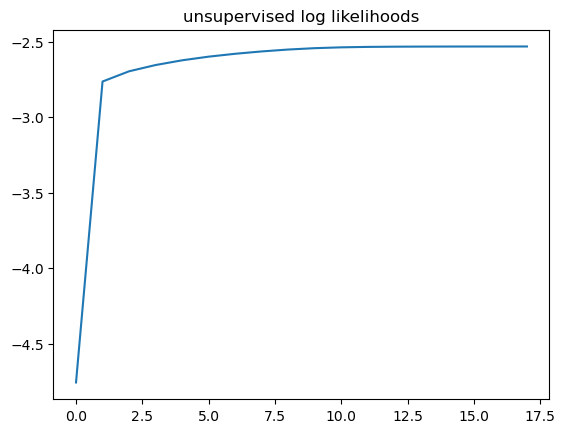

In [11]:
random_params = initialize_random_params()
unsupervised_forecastsforecasts, unsupervised_posterior, unsupervised_loglikelihoods = run_em(X, random_params)
print("total steps: ", len(unsupervised_loglikelihoods))
plt.plot(unsupervised_loglikelihoods)
plt.title("unsupervised log likelihoods")
plt.show


In [12]:
# Running the model
params = initialize_random_params()
model = run_em(X, params)

	phi: 0.4626104995525339
             	mu_0: [1.09437275 0.96993638]
             	mu_1: [-0.90275605 -0.956709  ]
             	sigma_0: [[0.80123869 0.2305169 ]
 [0.2305169  0.28970923]]
             	sigma_1: [[0.3838852  0.44417559]
 [0.44417559 1.06522602]]


	phi: 0.5240550384672212
             	mu_0: [-0.88337045 -0.91429705]
             	mu_1: [1.12758331 0.98044105]
             	sigma_0: [[0.39421274 0.46458538]
 [0.46458538 1.10538704]]
             	sigma_1: [[0.76987004 0.21838995]
 [0.21838995 0.28573078]]


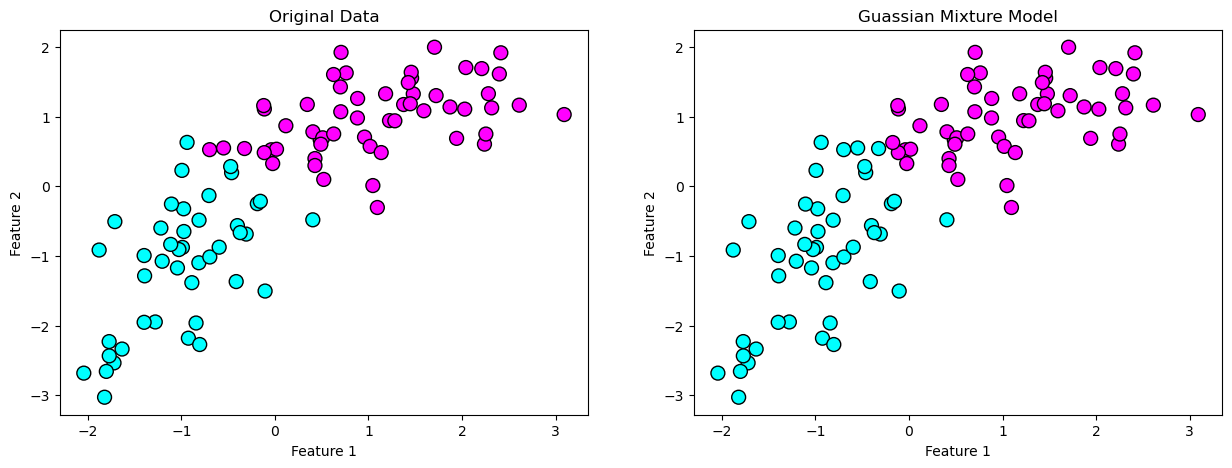

In [19]:
np.random.seed(0)

params = initialize_random_params()
model = run_em(X, params)


fa = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(X[:, 0],X[:, 1],c=data_unlabeled.y, cmap=plt.cm.cool, s = 100, edgecolor='black')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Original Data")



plt.subplot(1,2,2)
plt.scatter(X[:, 0],X[:, 1],c = model[0], cmap=plt.cm.cool, s = 100, edgecolor='black')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Guassian Mixture Model")
plt.show()